__NOTE:__ _This assignment for SMM750-DTVC shares overlapping elments with assignment for SMM636-ML. As a result, some of the code blocks were repurposed and adapted._

#  __0. LIBRARIES & OTHER__

## 0.1. Libraries

In [1]:
# Data Manipulation and Analysis
import pandas as pd
import numpy as np
import warnings

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning Models and Tools
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier , GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, auc, roc_curve, roc_auc_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.inspection import PartialDependenceDisplay
from sklearn.impute import SimpleImputer
from ISLP import confusion_table

# Imbalanced Learning
from scipy import stats

## 0.2. Other

In [2]:
# Set the Random Seed for the entire code
rng = 42

# Remove runtime warning (concerns gradient boost GridSearchCV())
warnings.filterwarnings("ignore", category=RuntimeWarning)

# __1. DATA & EDA__

## 1.1. Load and View the dataset

In [3]:
# Load the dataset and see its structure
df = pd.read_csv('employee_attrition_previous_closure.csv')
display(df.head())
df.shape

,Attrition,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,No,50.0,Travel_Rarely,1126.0,Research & Development,1.0,2,Medical,1,997,...,3,80,1,32,1,2,5,4,1,3
1,No,36.0,Travel_Rarely,216.0,Research & Development,6.0,2,Medical,1,178,...,4,80,2,7,0,3,3,2,0,1
2,Yes,21.0,Travel_Rarely,337.0,Sales,7.0,1,Marketing,1,1780,...,2,80,0,1,3,3,1,0,1,0
3,No,50.0,Travel_Frequently,1246.0,Human Resources,NaN,3,Medical,1,644,...,3,80,1,32,2,3,32,5,10,7
4,No,52.0,Travel_Rarely,994.0,Research & Development,7.0,4,Life Sciences,1,1118,...,4,80,0,18,4,3,8,6,4,0


(1029, 35)

In [4]:
# Check for data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029 entries, 0 to 1028
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition                 1029 non-null   object 
 1   Age                       893 non-null    float64
 2   BusinessTravel            1024 non-null   object 
 3   DailyRate                 1002 non-null   float64
 4   Department                1029 non-null   object 
 5   DistanceFromHome          934 non-null    float64
 6   Education                 1029 non-null   int64  
 7   EducationField            1029 non-null   object 
 8   EmployeeCount             1029 non-null   int64  
 9   EmployeeNumber            1029 non-null   int64  
 10  EnvironmentSatisfaction   1029 non-null   int64  
 11  Gender                    1029 non-null   object 
 12  HourlyRate                1029 non-null   int64  
 13  JobInvolvement            1029 non-null   int64  
 14  JobLevel

In [5]:
# Check how unbalanced the dataset is
num_no = (df['Attrition'] == 'No').sum()
num_yes = (df['Attrition'] == 'Yes').sum()
print(f"Number of 0s: {num_no}",
      f"\nNumber of 1s: {num_yes}",
      f"\nProportion: {num_yes/(num_no + num_yes):.2%}")

Number of 0s: 853 
Number of 1s: 176 
Proportion: 17.10%


## 1.2. Redundant & Problematic Features

In [6]:
#### CHECK FOR PROBLEMATIC DATA POINTS / FEATURES ####
# Check for missing values in the dataset
na_counts1 = df.isna().sum()
print(f"MISSING OBSERVATIONS FEATURES:\n{na_counts1[na_counts1 > 0]}")
print(f"Missing values percentage: {(df.isna().sum().sum() / df.shape[0] * 100):.2f}%")

print("-"*35)

# Check for fetures with only a single value
print("SINGLE VALUE FEATURES:")
for col in df.columns:
    if df[col].nunique() == 1:
        print(f"{col}: {df[col].unique()[0]}")

print("-"*35)

# Check if there is any employees that are observed more then once
print(f"DUPLICATED EMPLOYEE OBSERVATIONS: {df['EmployeeNumber'].duplicated().sum()}")

MISSING OBSERVATIONS FEATURES:
Age                 136
BusinessTravel        5
DailyRate            27
DistanceFromHome     95
MaritalStatus         5
dtype: int64
Missing values percentage: 26.04%
-----------------------------------
SINGLE VALUE FEATURES:
EmployeeCount: 1
Over18: Y
StandardHours: 80
-----------------------------------
DUPLICATED EMPLOYEE OBSERVATIONS: 0


From the output above one can see which values need to be removed due to being redundant, as well as features with missing values that will have to be dealt with. Below I do exactly that, with the addition of removing protected characteristics in accordance with the "CMS Expert Guide on Discrimination in the Workplace in France," which can be found at the link below.

LINK: https://cms.law/en/int/expert-guides/cms-expert-guide-on-discrimination-in-the-workplace/france

In [7]:
# Drop 'protected characteristics' and not useful for analysis columns
feature_drop = [
    'Age', 'Gender', 'MaritalStatus', 'RelationshipSatisfaction',  # Protected characteristics (assuming that 'RelationshipSatisfaction' concering the relationship at home)
    'EmployeeCount', 'Over18', 'StandardHours',                    # Not useful for analysis (single value features)
    'EmployeeNumber'                                               # Not useful for analysis (enique identifier)
]  
df.drop(feature_drop, axis=1, inplace=True)
df.shape  # check if they got removed

(1029, 27)

In [8]:
# Check for missing values in the updated dataset
na_counts2 = df.isna().sum()
print(f"Fetures with missing values:\n{na_counts2[na_counts2 > 0]}")
print(f"Missing values percentage: {(df.isna().sum().sum() / df.shape[0] * 100):.2f}%")

Fetures with missing values:
BusinessTravel       5
DailyRate           27
DistanceFromHome    95
dtype: int64
Missing values percentage: 12.34%


I was able to remove 53% of the missing values by removing protected characteristics. Considering the remaining made up 12% of all observations (127 observations of 1029), it was relatively acceptable to drop the observations with missing values. Before dropping them, I had attempted imputing them; however, the validation results were poorer than just removing the missing values from the dataset entirely.

It may be possible to use a more complex imputation method through (non-)random nearest neighbour draw, or by performing a regression/classification attempting to predict the missing values and fill them without a drop in model performance.

In [9]:
#### DEAL WITH MISSING VALUES ####
# Drop observations with missing values
df.dropna(inplace=True)

# Check for missinf values in the updated dataset
print(f"Number of NAs: {df.isna().sum().sum()} \nShape: {df.shape}")

Number of NAs: 0 
Shape: (905, 27)


Considering that all outliers are age-related and do not seem unreasonable, I will assume that there are several employees who are significantly more senior than the majority. Therefore, they are correct and not erroneous, which will need to be considered when choosing the models.

In [10]:
# Check for outliers in the dataset only on numeric columns
numeric_cols = df.select_dtypes(include='number').columns

# Calculate the z-scores for every numeric column and identify outliers (i.e., z > 3 or z < -3)
for col in numeric_cols:
    z = stats.zscore(df[col])
    outlier_mask = (z > 3) | (z < -3)
    outliers = df[col][outlier_mask]
    
    # If there are outliers presetn in the feature, print the feture name and the range of the otliers
    if not outliers.empty:
        n_outliers = outliers.count()
        min_val = outliers.min()
        max_val = outliers.max()
        print(f"{n_outliers} outliers in '{col}' ranging from {min_val} to {max_val}")

7 outliers in 'TotalWorkingYears' ranging from 36 to 40
14 outliers in 'YearsAtCompany' ranging from 26 to 37
8 outliers in 'YearsInCurrentRole' ranging from 16 to 18
23 outliers in 'YearsSinceLastPromotion' ranging from 12 to 15
9 outliers in 'YearsWithCurrManager' ranging from 15 to 17


## 1.3. Feature Engineering

In [11]:
# See the values of the 'object' class fetures and print them
object_columns = [
    'Attrition',
    'BusinessTravel',
    'Department',
    'EducationField',
    'JobRole',
    'OverTime'
]
for col in object_columns:
    print(f"Column: {col}")
    print(df[col].unique())

Column: Attrition
['No' 'Yes']
Column: BusinessTravel
['Travel_Rarely' 'Non-Travel' 'Travel_Frequently']
Column: Department
['Research & Development' 'Sales' 'Human Resources']
Column: EducationField
['Medical' 'Marketing' 'Life Sciences' 'Technical Degree' 'Other'
 'Human Resources']
Column: JobRole
['Research Director' 'Manufacturing Director' 'Sales Representative'
 'Healthcare Representative' 'Manager' 'Research Scientist'
 'Sales Executive' 'Laboratory Technician' 'Human Resources']
Column: OverTime
['No' 'Yes']


In [12]:
# Make binary variables into 0 and 1 variables
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})
df['OverTime'] = df['OverTime'].map({'Yes': 1, 'No': 0})

# Rename the binary variables for interpretation
df.rename({'Attrition_1': 'Attrition'}, axis=1, inplace=True)
df.rename({'OverTime_1': 'OverTime'}, axis=1, inplace=True)

# Convert categorical variables into dummy variables (i.e. one-hot encode them)
to_dummy = [
    'BusinessTravel',
    'Department',
    'EducationField',
    'JobRole'
]
df = pd.get_dummies(df, columns=to_dummy, drop_first=True)  # drop the first dummy to avoid multicollinearity
df.shape  # check if the dummies were added

(905, 40)

In [13]:
# Check how unbalanced is the processed dataset 
num_zero = (df['Attrition'] == 0).sum()
num_one = (df['Attrition'] == 1).sum()
print(f"Number of 0s: {num_zero}",
      f"\nNumber of 1s: {num_one}",
      f"\nProportion: {num_one/(num_zero + num_one):.2%}",
      f"\n\nNumber of positive values lost after pre-procesing: {num_yes - num_one} ({(num_yes - num_one)/num_yes:.2%})"
)

Number of 0s: 746 
Number of 1s: 159 
Proportion: 17.57% 

Number of positive values lost after pre-procesing: 17 (9.66%)


## 1.4. Distributions of the features

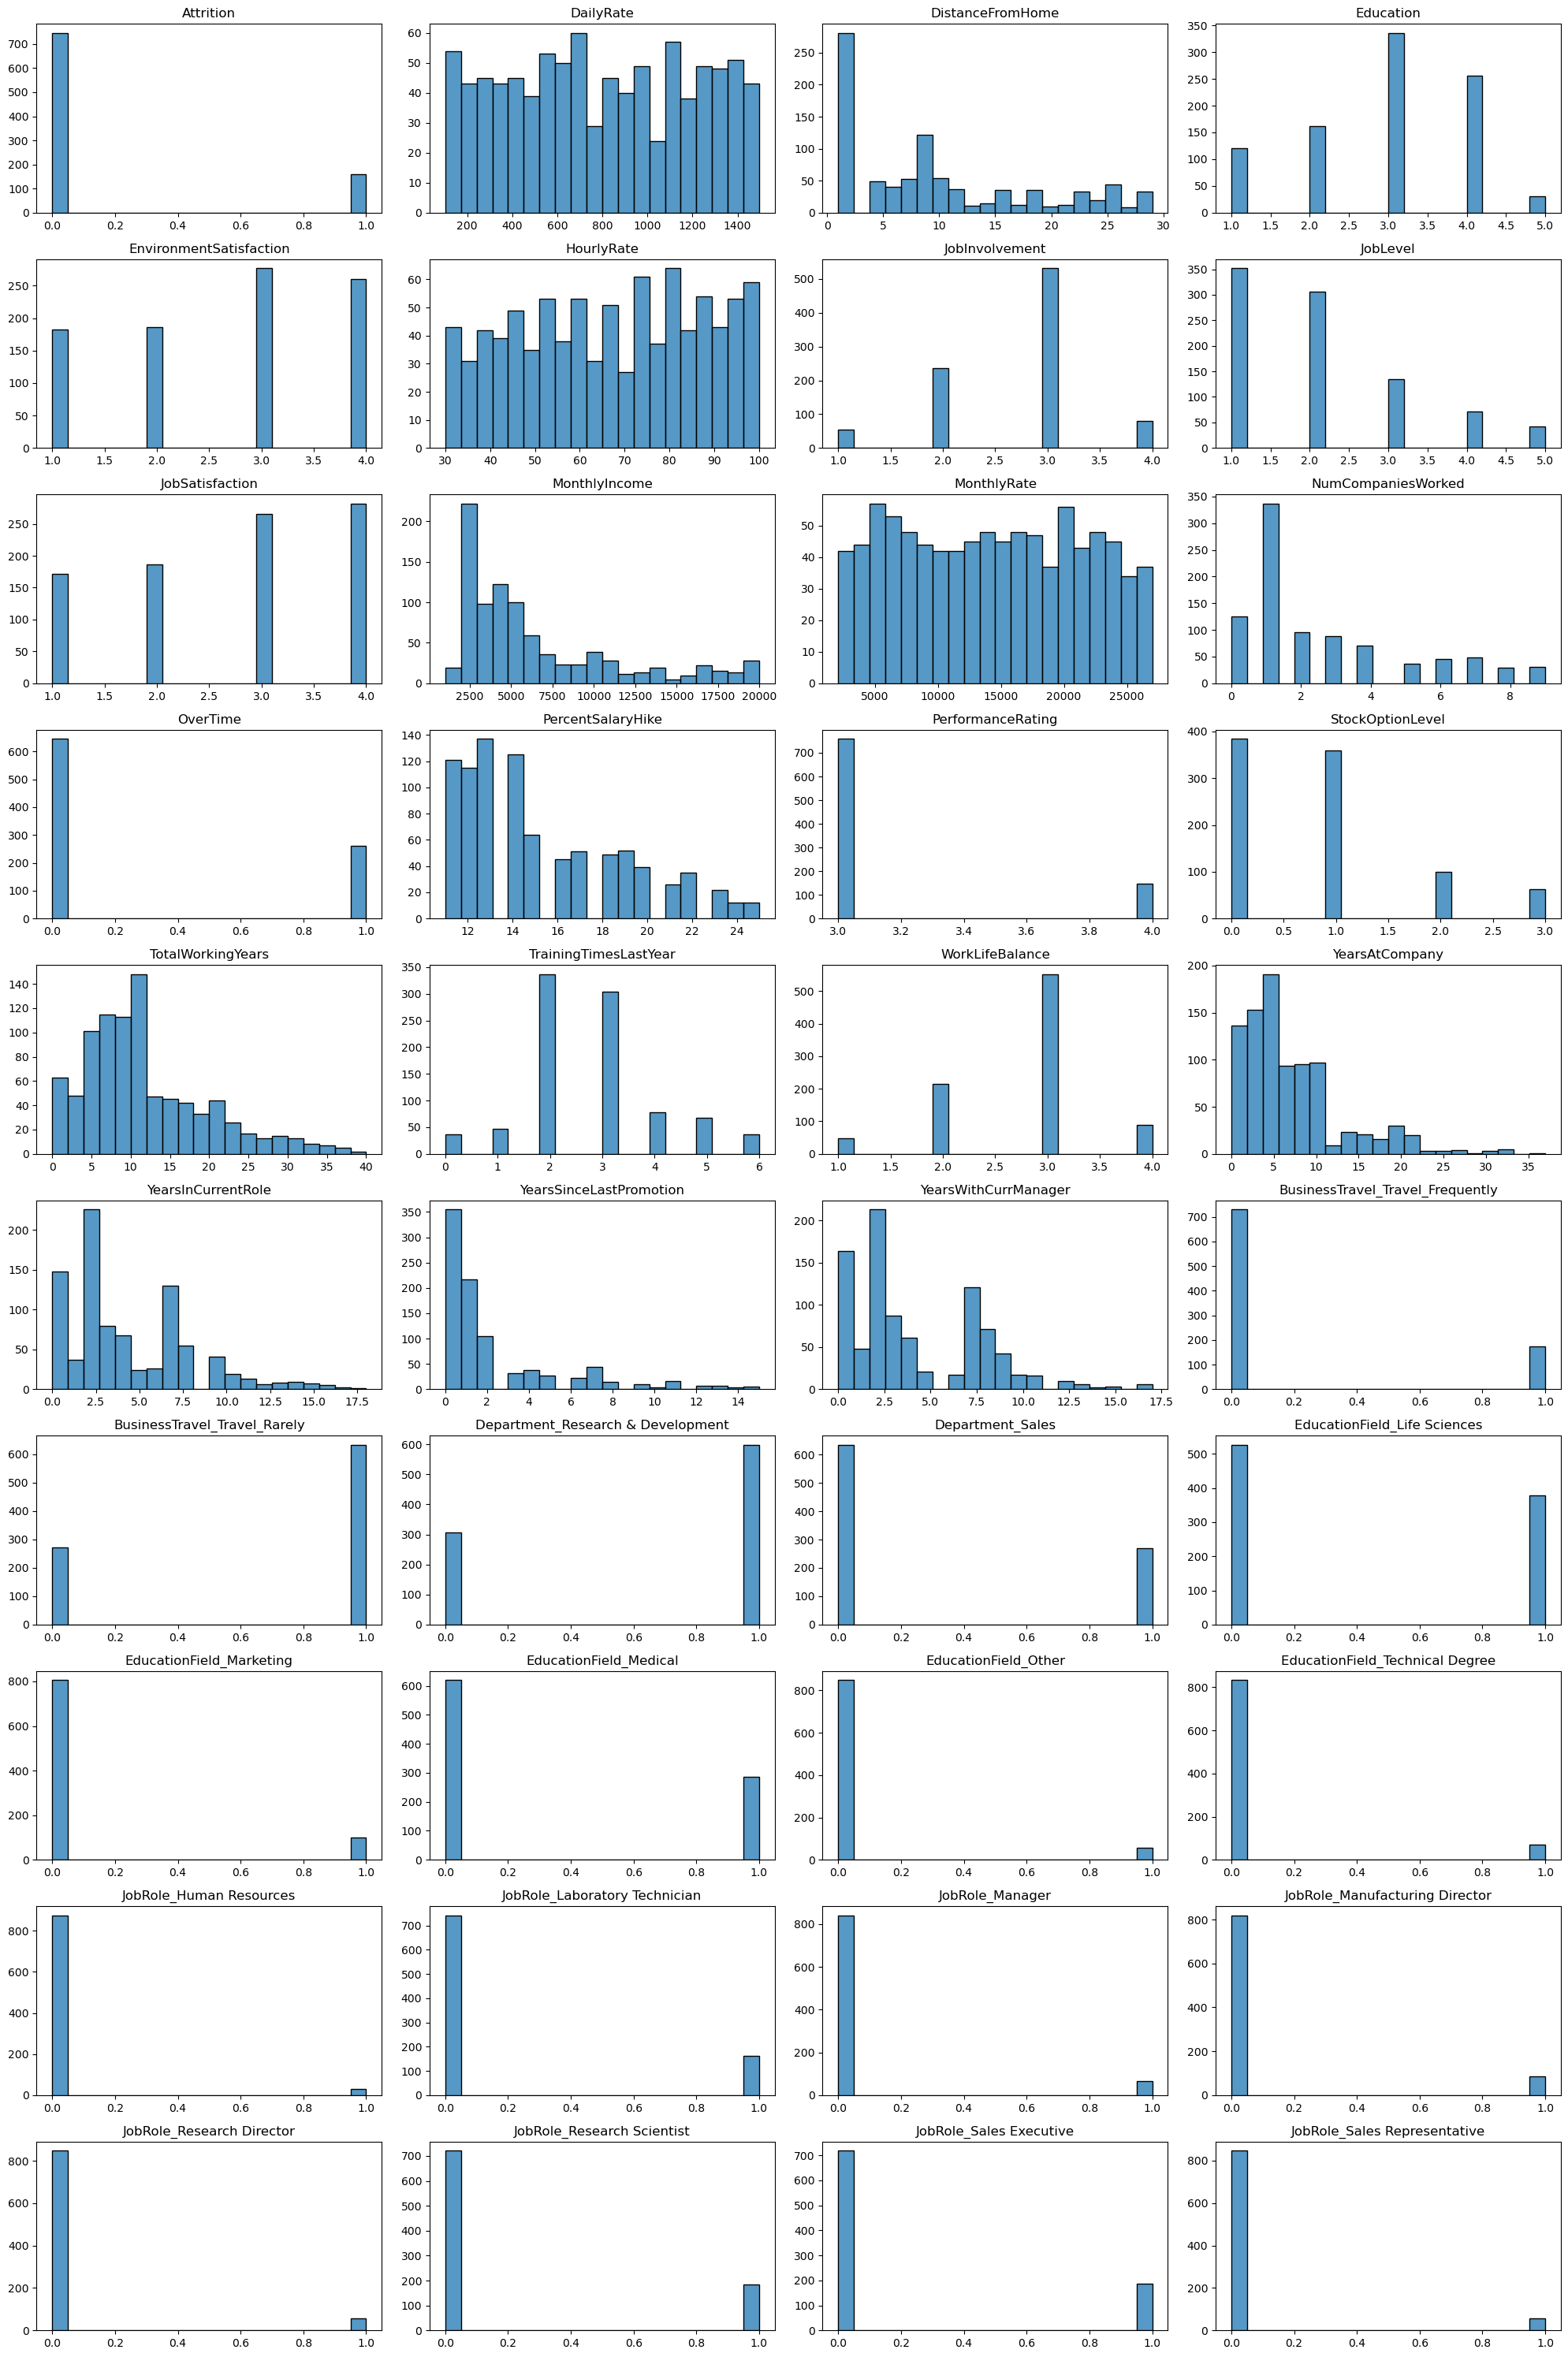

In [14]:
# Set up the figure
fig, axes = plt.subplots(10, 4, figsize=(20, 30))
axes = axes.flatten()  # Flatten in case of 2D grid

# Plot each histograms for each column
for i, col in enumerate(df.columns):
    sns.histplot(df[col], 
                 bins=20, 
                 kde=False, 
                 ax=axes[i])
    axes[i].set_title(f"{col}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
plt.tight_layout()
plt.show()

## 1.5. Correlation of features

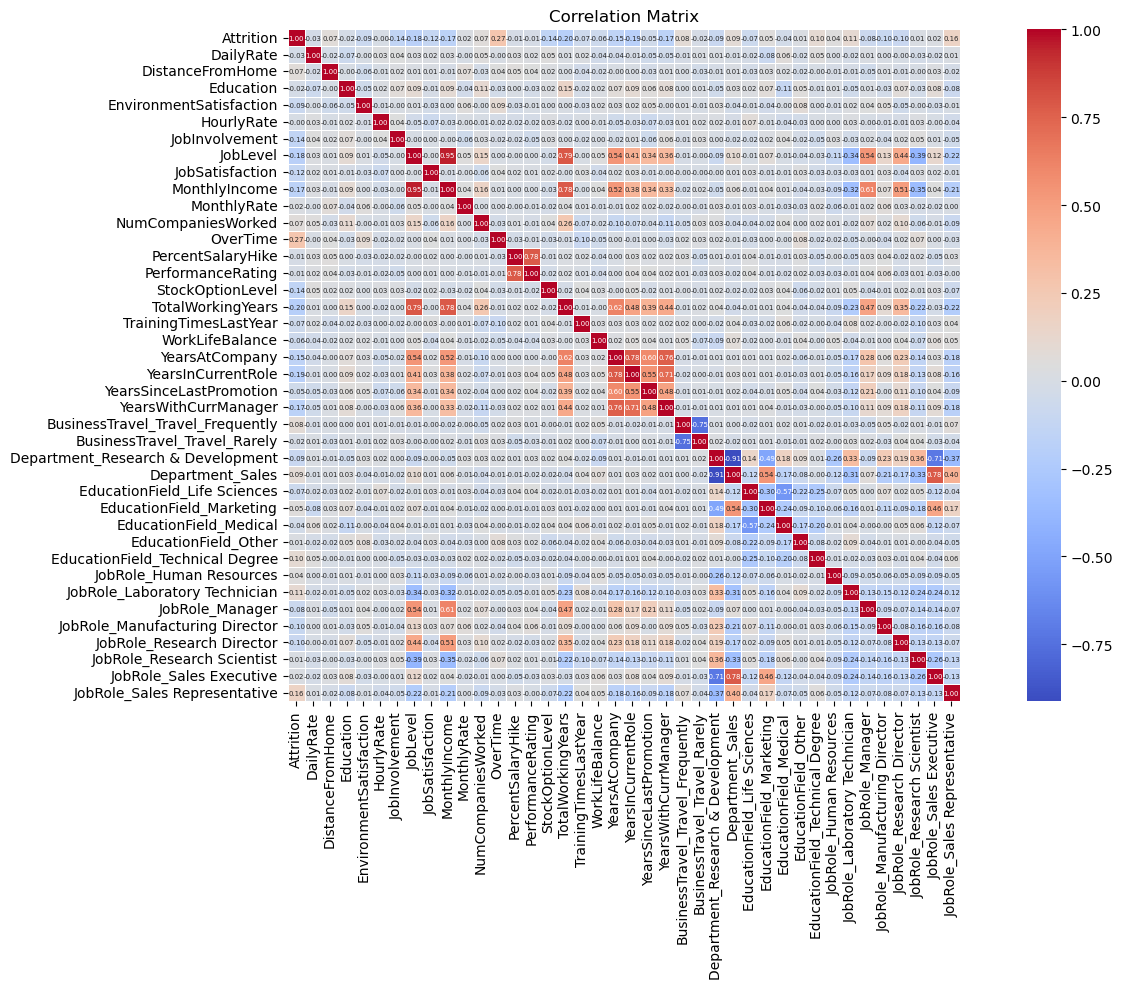

In [15]:
# Compute the correlation matrix
corr = df.corr()

# Set up the figure
plt.figure(figsize=(15, 10))

# Create & plot the heatmap
sns.heatmap(corr, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm', 
            square=True, 
            linewidths=0.5, 
            annot_kws={"size": 5})
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


## 1.6. Train & Test Split

In [16]:
# slit the data into train and test sets
y = df['Attrition']
X = df.drop(columns=['Attrition'])

# Since I am going to be performing k-fold CV, I will not use a separate validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng, stratify=y)
print(f"Shapes after train-test split:\nX_train: {X_train.shape} \nX_test: {X_test.shape} \ny_train: {y_train.shape} \ny_test: {y_test.shape}")

Shapes after train-test split:
X_train: (724, 39) 
X_test: (181, 39) 
y_train: (724,) 
y_test: (181,)


# __2. MODELS__

From the section above, we can observe:
- Presence of outliers (Z-score)
- Collinearity of fetures (Correlation plot)
- Target class imbalance ('Attrition')
- Features could need standardization

These issues would affect models like Logistic Regression, kNN, SVM, and other linear models. However, performing the necessary pre-processing steps (e.g., feature interactions) to make these models work was reducing correlation with the target class. Therefore, I chose to use inherently robust tree-based models (i.e., DecisionTree, Bagging, RandomForest, GradientBoosting), which are capable of handling the mentioned issues without requiring data transformation or losing data. (I have attempted performing SMOTE to balance remove the imbalnce, but the models performed significantly worse)

Additionally, since my primary goal is to distinguish between employees who are likely to leave vs. stay, rather than maximizing accuracy, I will use 'roc_auc' as my scoring metric for GridSearchCV() to have a more reliable measure of class separation. It will also slightly help to account for imbalance in this dataset.

## 2.1. Decision Tree

The parameter ranges for param_grid_dt were chosen after running on larger ranges:

- "ccp_alpha": np.arange(0, 10, 0.01)
- "max_leaf_nodes": np.arange(2, 51)

I then narrowed them to reduce runtime for the marker, while still capturing the optimal values.

In [17]:
# Define the hyperparameter grid
param_grid_tree = {
    "ccp_alpha": np.arange(0, 0.1, 0.01),
    "max_leaf_nodes": np.arange(2, 11)
}

# Initialize the GridSearchCV scoring based on best AUC for DecisionTreeClassifier
treeCV = GridSearchCV(
    DecisionTreeClassifier(
        random_state=rng, 
        class_weight='balanced'  # adjusts weights inversely proportional to class frequencies (helps with class imbalance)
    ), 
    param_grid_tree, 
    cv=10,     # number of CV folds
    scoring='roc_auc',
    n_jobs=-1  # use all of the cpu cores available
)

# Fit grid search on the training data
treeCV.fit(X_train, y_train)

# Get best estimator
tree_model = treeCV.best_estimator_

# Print the best parameters and the corresponding score
print("Best DecisionTreeClassifier parameters found:", treeCV.best_params_)
print("Best DecisionTreeClassifier cross-validated AUC:", treeCV.best_score_)

Best DecisionTreeClassifier parameters found: {'ccp_alpha': 0.0, 'max_leaf_nodes': 5}
Best DecisionTreeClassifier cross-validated AUC: 0.7587825039837751


In [18]:
# Compute the accuracy 
ypred_treeCV = treeCV.predict(X_test)
print("treeCV Accuracy:", accuracy_score(y_test, ypred_treeCV))

# Compute the ROC AUC 
yscores_treeCV = treeCV.predict_proba(X_test)[:, 1]  # Get predicted probabilities for positive class
treeCV_roc_auc = roc_auc_score(y_true=y_test, y_score=yscores_treeCV, multi_class="ovr", average="micro")
print(f"treeCV ROC AUC: {treeCV_roc_auc}")

# Get the classification report
print("\ntreeCV Classification Report:")
print(classification_report(y_test, ypred_treeCV))

# Get the confusion matrix
print("\ntreeCV Confusion Matrix:")
confusion_table(ypred_treeCV, y_test)

treeCV Accuracy: 0.8176795580110497
treeCV ROC AUC: 0.717596476510067

treeCV Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       149
           1       0.49      0.53      0.51        32

    accuracy                           0.82       181
   macro avg       0.69      0.71      0.70       181
weighted avg       0.82      0.82      0.82       181


treeCV Confusion Matrix:


Truth,0,1
Predicted,,
0,131,15
1,18,17


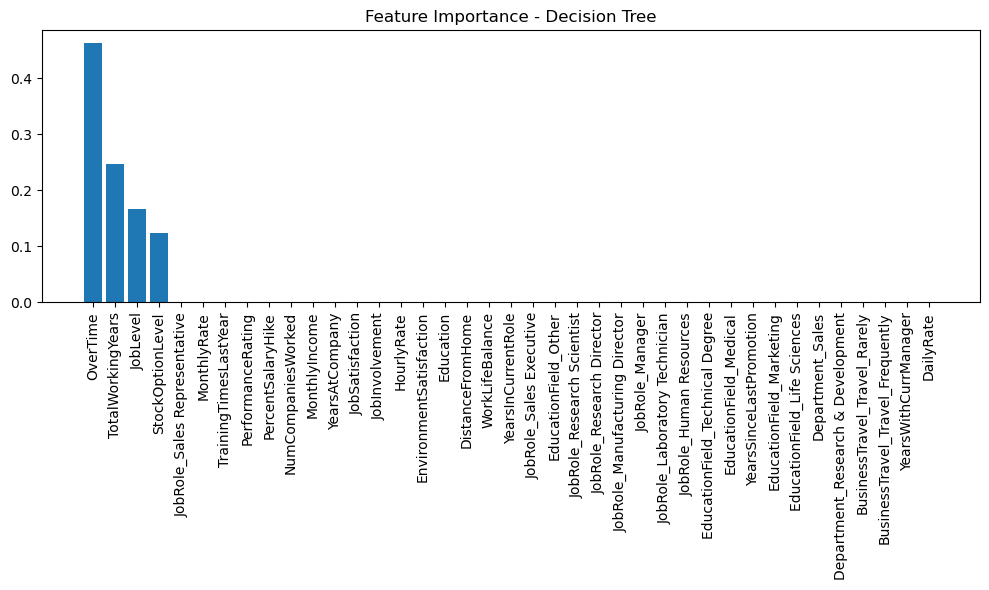

In [19]:
# Get feature importances from the fitted model
importances = tree_model.feature_importances_
features = X_train.columns

# Sort by importance
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importance - Decision Tree")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), features[indices], rotation=90)
plt.tight_layout()
plt.show()

## 2.2. Bagging

The parameter ranges for param_grid_bag were chosen after running on larger ranges:

- "max_features": np.arange(1,40) 
- I did not tune "n_estimators", since it would take too long and 500 trees is sufficient in most cases.

I then narrowed the range to reduce runtime for the marker, while still capturing the optimal values.

In [20]:
# Define the hyperparameter grid
param_grid_bag = {
    "max_features": np.arange(35,40)
}

# Initialize the GridSearchCV scoring based on best AUC for BaggingClassifier
bagCV = GridSearchCV(
    BaggingClassifier(
        DecisionTreeClassifier(
            ccp_alpha=tree_model.ccp_alpha,
            max_leaf_nodes=tree_model.get_n_leaves(),
            class_weight='balanced',  # adjusts weights inversely proportional to class frequencies (helps with class imbalance)
            random_state=rng
        ),
        n_estimators=500,  # trees to build
        bootstrap=True,    # sampling with replacement
        oob_score=True,    # built-in validation
        random_state=rng
    ),
    param_grid_bag,
    cv=10,     # number of CV folds
    scoring='roc_auc',
    n_jobs=-1  # use all available cores
)

# Fit grid search on the training data
bagCV.fit(X_train, y_train)

# Get best estimator
bag_model = bagCV.best_estimator_

# Print the best parameters and the corresponding score
print("Best BaggingClassifier parameters found:", bagCV.best_params_)
print("Best BaggingClassifier cross-validated AUC:", bagCV.best_score_)

Best BaggingClassifier parameters found: {'max_features': 37}
Best BaggingClassifier cross-validated AUC: 0.7781642039692886


In [21]:
# Compute the accuracy 
ypred_bagCV = bagCV.predict(X_test)
print("bagCV Accuracy:", accuracy_score(y_test, ypred_bagCV))

# Compute the ROC AUC 
yscores_bagCV = bagCV.predict_proba(X_test)[:, 1]  # Get predicted probabilities for positive class
bagCV_roc_auc = roc_auc_score(y_true=y_test, y_score=yscores_bagCV, multi_class="ovr", average="micro")
print(f"bagCV ROC AUC: {bagCV_roc_auc}")

# Get the classification report
print("\nbagCV Classification Report:")
print(classification_report(y_test, ypred_bagCV))

# Get the confusion matrix
print("\nbagCV Confusion Matrix:")
confusion_table(ypred_bagCV, y_test)

bagCV Accuracy: 0.8176795580110497
bagCV ROC AUC: 0.8013842281879194

bagCV Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89       149
           1       0.49      0.56      0.52        32

    accuracy                           0.82       181
   macro avg       0.69      0.72      0.70       181
weighted avg       0.83      0.82      0.82       181


bagCV Confusion Matrix:


Truth,0,1
Predicted,,
0,130,14
1,19,18


## 2.3. Random Forest

The parameter ranges for param_grid_forest were chosen after running on larger ranges:

- "max_features": np.arange(35,40,1)
- I did not tune "n_estimators", since it would take too long and 500 trees is sufficient in most cases.

I then narrowed the range to reduce runtime for the marker, while still capturing the optimal values.

In [22]:
# Define the hyperparameter grid
param_grid_forest = {
    "max_features": np.arange(35,40,1)  # same candidate values
}

# Initialize the GridSearchCV scoring based on best AUC for RandomForestClassifier
forestCV = GridSearchCV(
    RandomForestClassifier(
        max_leaf_nodes=tree_model.get_n_leaves(),
        ccp_alpha=tree_model.ccp_alpha,
        n_estimators=500,         # trees to build
        bootstrap=True,           # sampling with replacement
        oob_score=True,           # built-in validation
        class_weight='balanced',  # adjusts weights inversely proportional to class frequencies (helps with class imbalance)
        random_state=rng
    ),
    param_grid=param_grid_forest,
    cv=10,     # number of CV folds
    scoring='roc_auc',
    n_jobs=-1  # use all available cores
)

# Fit grid search on the training data
forestCV.fit(X_train, y_train)

# Get best estimator
forest_model = forestCV.best_estimator_

# Print the best parameters and the corresponding score
print("Best BaggingClassifier parameters found:", forestCV.best_params_)
print("Best BaggingClassifier cross-validated AUC:", forestCV.best_score_)

Best BaggingClassifier parameters found: {'max_features': 38}
Best BaggingClassifier cross-validated AUC: 0.778805772852383


In [23]:
# Compute the accuracy 
ypred_forestCV = forestCV.predict(X_test)
print("forestCV Accuracy:", accuracy_score(y_test, ypred_forestCV))

# Compute the ROC AUC 
yscores_forestCV = forestCV.predict_proba(X_test)[:, 1]  # Get predicted probabilities for positive class
forestCV_roc_auc = roc_auc_score(y_true=y_test, y_score=yscores_forestCV, multi_class="ovr", average="micro")
print(f"forestCV ROC AUC: {forestCV_roc_auc}")

# Get the classification report
print("\nforestCV Classification Report:")
print(classification_report(y_test, ypred_forestCV))

# Get the confusion matrix
print("\nforestCV Confusion Matrix:")
confusion_table(ypred_forestCV, y_test)

forestCV Accuracy: 0.8176795580110497
forestCV ROC AUC: 0.7942533557046979

forestCV Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89       149
           1       0.49      0.56      0.52        32

    accuracy                           0.82       181
   macro avg       0.69      0.72      0.70       181
weighted avg       0.83      0.82      0.82       181


forestCV Confusion Matrix:


Truth,0,1
Predicted,,
0,130,14
1,19,18


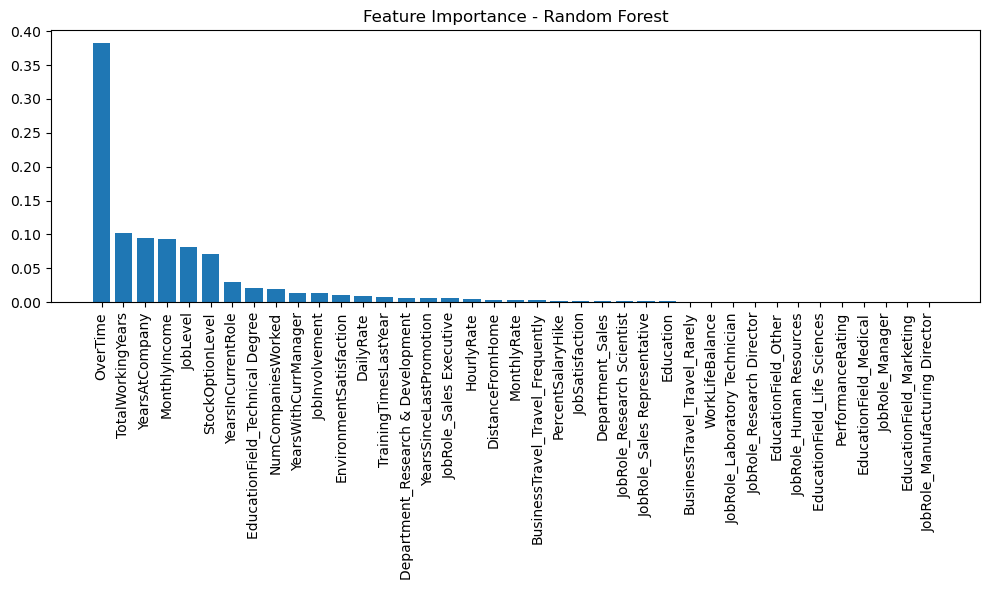

In [24]:
# Get feature importances from the fitted model
importances = forest_model.feature_importances_
features = X_train.columns

# Sort by importance
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importance - Random Forest")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), features[indices], rotation=90)
plt.tight_layout()
plt.show()

## 2.4. Gradient Boosting

The parameter ranges for param_grid_boost were chosen after running on larger ranges:

- "learning_rate": np.arange(0.01, 5, 0.01)
- "max_depth": np.arange(1, 5, 1)
- "max_leaf_nodes": np.arange(2, 5, 1)
- "min_samples_split": np.arange(2, 5, 1)
- I attempted to run 500 trees; however, it took more than 30 minutes (100 takes 6 minutes with the ranges above).

I then narrowed the range to reduce runtime for the marker, while still capturing the optimal values.

In [25]:
# Define the hyperparameter grid
param_grid_boost = {
    "learning_rate": np.arange(0.01, 0.15, 0.01),
    "max_depth": np.arange(1, 4, 1),
    "max_leaf_nodes": np.arange(2, 4, 1),
    "min_samples_split": np.arange(2, 4, 1)
}

# Initialize the GridSearchCV scoring based on best AUC for GradientBoostingClassifier
boostCV = GridSearchCV(
    GradientBoostingClassifier(
        n_estimators=100,  # trees to build 
        random_state=rng
    ),
    param_grid=param_grid_boost,
    cv=10,     # number of CV folds
    scoring='roc_auc',
    n_jobs=-1  # use all available cores
)

# Fit GridSearchCV on the training data while adjusting the weights
weights = compute_sample_weight(class_weight='balanced', y=y_train)  # adjusts weights inversely proportional to class frequencies (helps with class imbalance)
boostCV.fit(X_train, y_train, sample_weight=weights)

# Get best estimator
boost_model = boostCV.best_estimator_

# Print the best parameters and the corresponding score
print("Best GradientBoostingClassifier parameters found:", boostCV.best_params_)
print("Best GradientBoostingClassifier cross-validated AUC:", boostCV.best_score_)


Best GradientBoostingClassifier parameters found: {'learning_rate': 0.11, 'max_depth': 2, 'max_leaf_nodes': 3, 'min_samples_split': 2}
Best GradientBoostingClassifier cross-validated AUC: 0.8225425539620455


In [26]:
# Compute the accuracy 
ypred_boostCV = boostCV.predict(X_test)
print("boostCV Accuracy:", accuracy_score(y_test, ypred_boostCV))

# Compute the ROC AUC 
yscores_boostCV = boostCV.predict_proba(X_test)[:, 1]  # Get predicted probabilities for positive class
boostCV_roc_auc = roc_auc_score(y_true=y_test, y_score=yscores_boostCV, multi_class="ovr", average="micro")
print(f"boostCV ROC AUC: {boostCV_roc_auc}")

# Get the classification report
print("\nboostCV classification report:")
print(classification_report(y_test, ypred_boostCV))

# Get the confusion matrix
print("\nboostCV confusion matrix Report:")
confusion_table(ypred_boostCV, y_test)

boostCV Accuracy: 0.8342541436464088
boostCV ROC AUC: 0.8643036912751678

boostCV classification report:
              precision    recall  f1-score   support

           0       0.92      0.87      0.90       149
           1       0.53      0.66      0.58        32

    accuracy                           0.83       181
   macro avg       0.72      0.76      0.74       181
weighted avg       0.85      0.83      0.84       181


boostCV confusion matrix Report:


Truth,0,1
Predicted,,
0,130,11
1,19,21


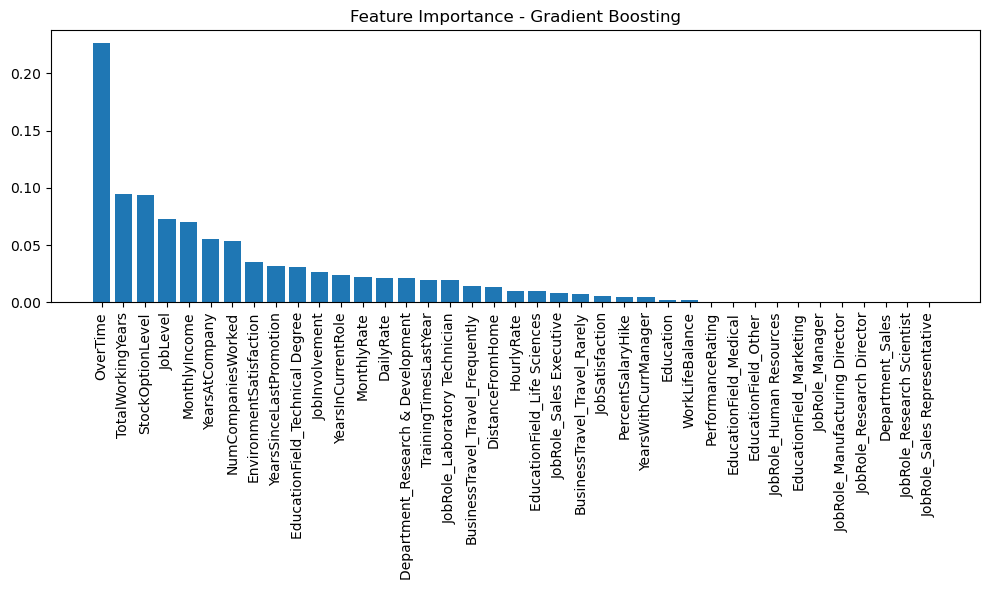

In [27]:
# Get feature importances from the fitted model
importances = boost_model.feature_importances_
features = X_train.columns

# Sort by importance
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importance - Gradient Boosting")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), features[indices], rotation=90)
plt.tight_layout()
plt.show()

# __3. MODEL COMPARISON__

## 3.1. ROC Curves

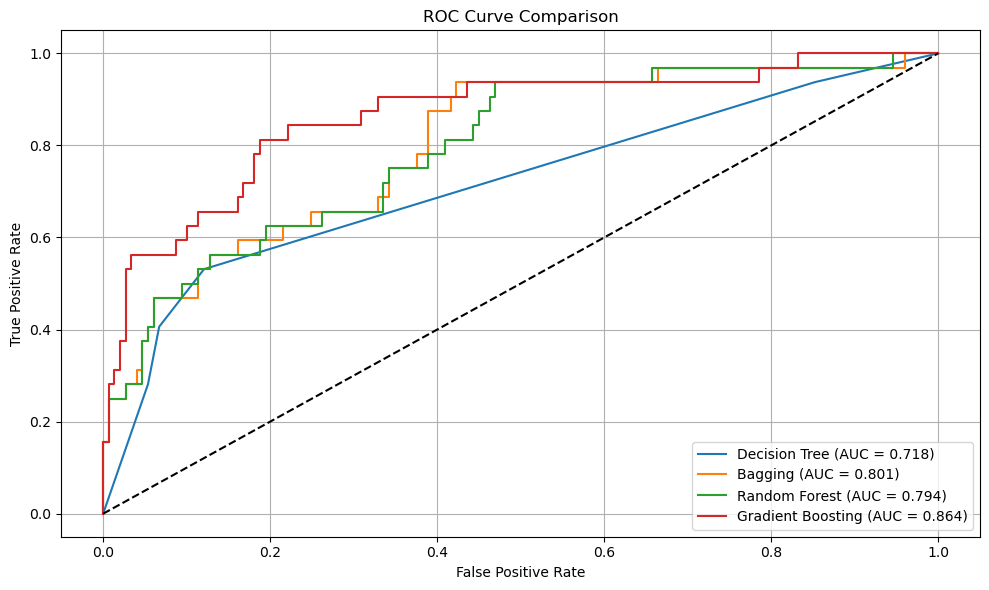

In [28]:
# Compute ROC curves
fpr_tree, tpr_tree, _ = roc_curve(y_test, yscores_treeCV)     # Decision Tree
fpr_bag, tpr_bag, _ = roc_curve(y_test, yscores_bagCV)        # Bagging
fpr_rf, tpr_rf, _ = roc_curve(y_test, yscores_forestCV)       # Random Forest
fpr_boost, tpr_boost, _ = roc_curve(y_test, yscores_boostCV)  # Gradient Boosting


# Plot all ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_tree, tpr_tree, label=f'Decision Tree (AUC = {treeCV_roc_auc:.3f})')         # Decision Tree
plt.plot(fpr_bag, tpr_bag, label=f'Bagging (AUC = {bagCV_roc_auc:.3f})')                  # Bagging
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {forestCV_roc_auc:.3f})')           # Random Forest
plt.plot(fpr_boost, tpr_boost, label=f'Gradient Boosting (AUC = {boostCV_roc_auc:.3f})')  # Gradient Boosting

# Plot random guess line
plt.plot([0, 1], [0, 1], 'k--')

# Formatting
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

## 3.2. Validation and Test Scores

In [29]:
# Create a list of models and their corresponding labels
models = {
    "Decision Tree": (tree_model, treeCV),
    "Bagging": (bag_model, bagCV),
    "Random Forest": (forest_model, forestCV),
    "Gradient Boosting": (boost_model, boostCV)
}

# Store predictions
preds = {
    "Decision Tree": ypred_treeCV,
    "Bagging": ypred_bagCV,
    "Random Forest": ypred_forestCV,
    "Gradient Boosting": ypred_boostCV
}

# Store ROC AUC scores
auc_scores = {
    "Decision Tree": treeCV_roc_auc,
    "Bagging": bagCV_roc_auc,
    "Random Forest": forestCV_roc_auc,
    "Gradient Boosting": boostCV_roc_auc
}

# Print formatted table
print(f"{'Model':<20}{'Test Acc':<12}{'Test AUC':<10}|  {'CV Acc':<10}{'CV AUC'}")
print("-"*41, "|", "-"*17)

# Get the Accuracy and AUC for each model using the test and CV sets
for name, (model, cv_obj) in models.items():
    test_acc = accuracy_score(y_test, preds[name])
    test_auc = auc_scores[name]

    cv_acc = cross_val_score(model, X_train, y_train, cv=10, scoring='roc_auc', n_jobs=-1).mean()  # since i did not make a separate validation set, this gets the mean CV scores from GridSearchCV()
    cv_auc = cv_obj.best_score_
    
    print(f"{name:<20}{test_acc:<12.3f}{test_auc:<10.3f}|  {cv_acc:<10.3f}{cv_auc:.3f}")


Model               Test Acc    Test AUC  |  CV Acc    CV AUC
----------------------------------------- | -----------------
Decision Tree       0.818       0.718     |  0.759     0.759
Bagging             0.818       0.801     |  0.778     0.778
Random Forest       0.818       0.794     |  0.779     0.779
Gradient Boosting   0.834       0.864     |  0.803     0.823


Looking at each model closely, in Section 2 and looking at them side by side in the ROC Curves (Section 3.1) table above (Section 3.2), we can observe that the best performing model across all used metrics was the Gradient Boosting model and therefore will be the model used for future tasks. To further validate this choice, the Gradient Boosting model had the best TPR of 66%, more than 10% improvement compared to other tested models. Considering that we want to ensure that we capture as many as possible employees who would take RCC, I chose the Gradient Boosting model.

TPR is crucial, since false negatives would lead to underestimation of the budget required to compensate all accepted RCC deals, potentially causing budgetary issues or resulting in some employees not receiving an RCC even though they were given the choice. Threshold optimization could improve the TPR further, however, without costs associated with false positives (giving an employee an RCC who would not leave) and additional costs from false negatives which may not be monetary (e.g., employee perception of the company worsens), it would be hard to find a fair threshold through optimization of costs. 

Provided these costs, I could use the information from the SFB study to estimate average salary (i.e., EUR 3 million yearly salary saved from letting go 40 employees) and select one of the minimum RCC calculations from Appendix A2 of the study. Since I lack this information, I will use the model as it is at 0.5 threshold (using Youden’s J statistic, it sets the threshold at 0.52, but reduces TPR).

# __4. IMPORTANT FEATURES__

## 4.1. Feature Importance Plots

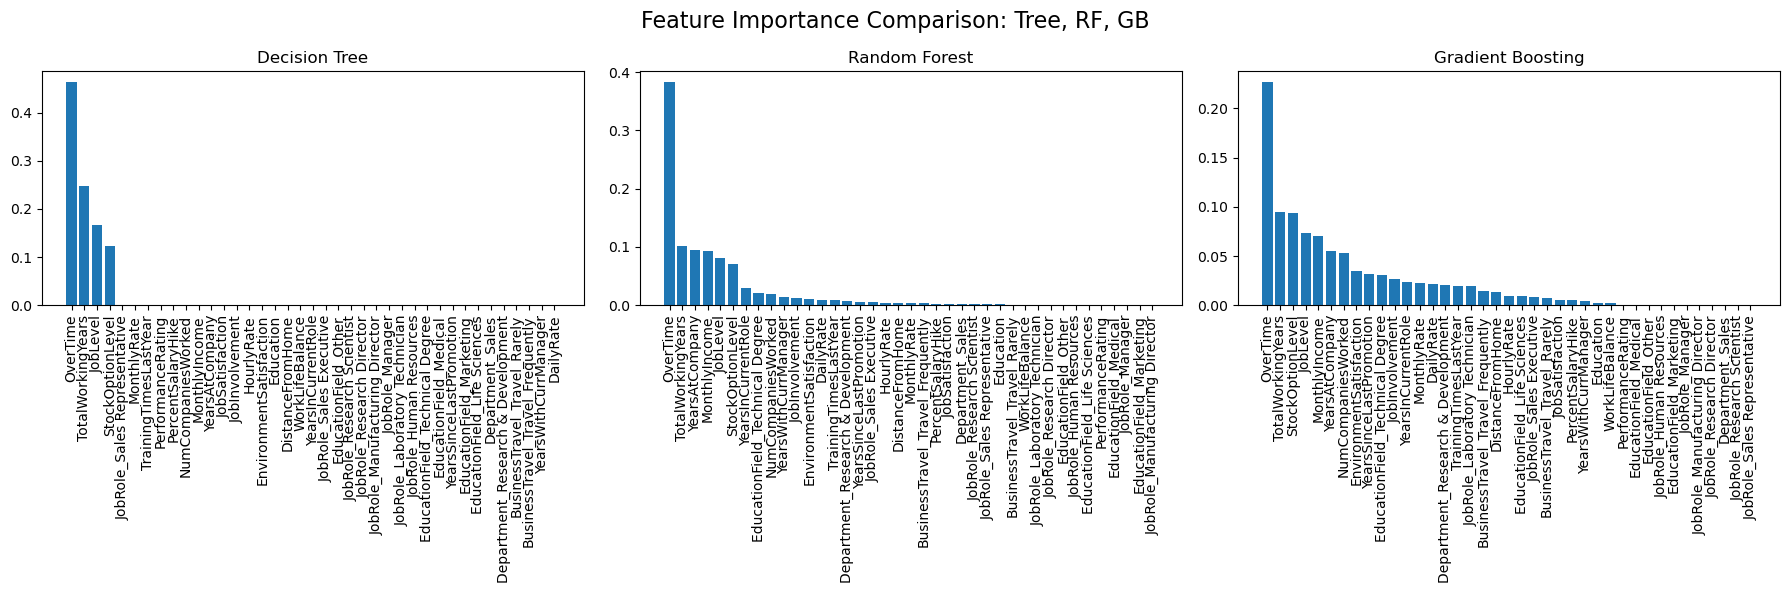

In [30]:
# Get feature names and total number of features
features = X_train.columns
n_features = len(features)

# Create subplots: 1 row, 3 columns for comparing models
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Feature Importance Comparison: Tree, RF, GB", fontsize=16)

# Dictionary of models to compare
models = {
    "Decision Tree": tree_model,
    "Random Forest": forest_model,
    "Gradient Boosting": boost_model
}

# Loop through models and corresponding axes to plot importances
for ax, (title, model) in zip(axs, models.items()):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]  # Sort features by importance
    
    # Plot
    ax.bar(range(n_features), importances[indices], align="center")
    ax.set_title(title)
    ax.set_xticks(range(n_features))
    ax.set_xticklabels(features[indices], rotation=90)  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()


The feature importance plots above show the variables that are most influential in predicting employee attrition (presented RCC) across our models. However, these plots do not provide information on the direction of each feature's effect. To explore how these features impact the target, I used Partial Dependence Plots (only on the Gradient Boosting model), allowing me to see how changes in the features affect the likelihood of an employee accepting RCC.

## 4.2. Partial Dependence Plots

I chose the top 9 features (for presentation purposes) of the Gradient Boosting model, but it is important to note that the majority also appeared as top predictors in other models as well.

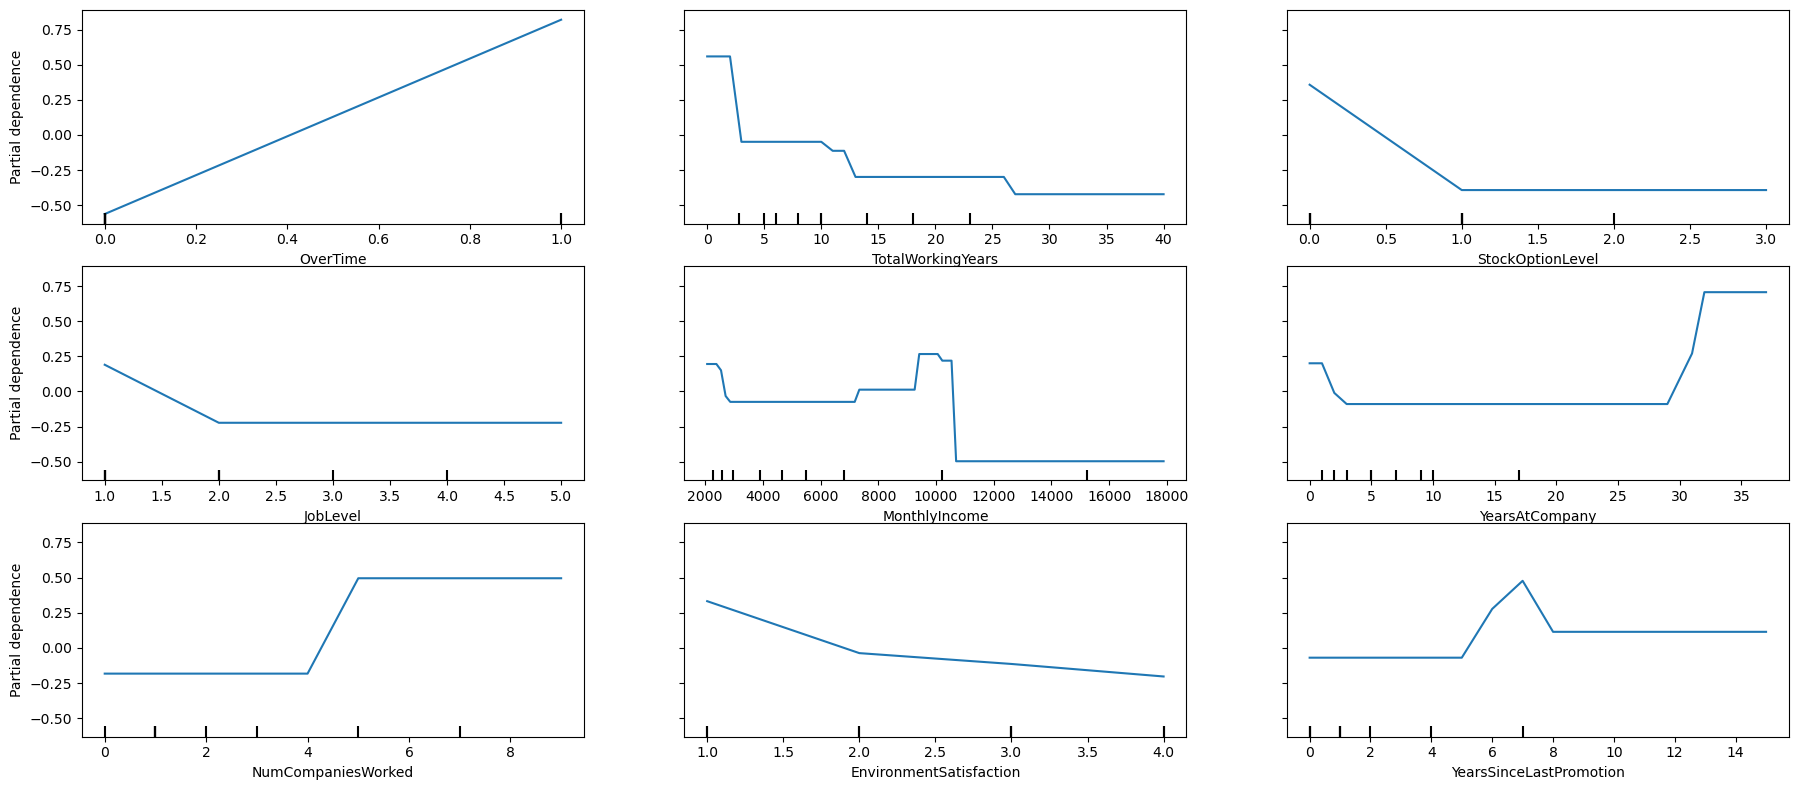

In [31]:
# List of top 9 features of gradient boosting model
features_to_plot = ['OverTime', 'TotalWorkingYears', 'StockOptionLevel', 
                    'JobLevel', 'MonthlyIncome', 'YearsAtCompany', 
                    'NumCompaniesWorked', 'EnvironmentSatisfaction', 'YearsSinceLastPromotion']

# Plot PDPs
fig, ax = plt.subplots( figsize=(18, 8))  # adjust size as needed
PartialDependenceDisplay.from_estimator(
    boost_model,       # model choise
    X_train,           # test data
    features_to_plot,  # top 9 features
    kind="average",    # take the average of all observation instead of each 'individual' observation
    n_jobs=-1,         # use all available cores
    ax=ax
)
plt.tight_layout()
plt.show()


__Key Findings from PDPs:__

- __OverTime__ – was the most influential feature across all models. Employees who work overtime are significantly more likely to accept the RCC. While the company is looking for people to leave, it is important to remember this even after the merger finishes, to address possible burnout (leading to unwanted turnover).

- __TotalWorkingYears__ – employees with fewer years of work experience are seen to be more likely to accept RCC. This can reflect lower job attachment.

- __StockOptionLevel, JobLevel, MonthlyIncome__ – are all proxies of seniority, where employees with lower seniority are more likely to accept the RCC and leave. Although income could also be a singular reason, considering it correlates with JobLevel (see part 1.5), it is likely showing seniority.

- __YearsAtCompany__ – the shorter the tenure (below 3 years), the more likely the employee is to leave accepting RCC. There is a spike after 30 years, showing even more likelihood of leaving than those with short tenures. This range was previously flagged as outliers (see part 1.3) and are likely approaching retirement; RCC may act as an incentive.

- __NumCompaniesWorked__ – employees who worked in more than 4 companies show a significant increase in likelihood of accepting RCC. This aligns with the possibility that they are more experienced in changing jobs and therefore foresee less turmoil after leaving their current role with RCC.

- __EnvironmentSatisfaction__ – lower satisfaction shows a higher likelihood of accepting RCC. Together with overtime, this shows that satisfaction is a significant reason for deciding to leave.

- __YearsSinceLastPromotion__ – employees who have not been promoted in a long time show a higher likelihood of accepting RCC. This is likely due to the feeling of stagnation in the current job location, while RCC can be perceived as an incentive to look for career growth elsewhere.

---

By taking a closer look at the important features in our model, we can guide part 3 of the assignment: strategically offering RCC to groups that are more likely to accept it.

Specifically, employees who:
- Work overtime  
- Have lower tenures  
- Are in lower-ranking roles  
- Have not been promoted recently  
- Have >4 previous jobs  

Clustering employees in these groups could prove beneficial for offering RCCs, but will need to be checked to follow anti-discriminatory practices and ensure they do not make up more than 20% of any one department.


# __5. FIT BEST MODEL__

## 5.1. Re-fit the gradient Boost model, now using both train and test data

In [32]:
# Trainign the Gradient Boost model on the entire 'employee_attrition_previous_closure.csv' dataset with best found parameters
best_model = GradientBoostingClassifier(
    learning_rate=0.11,
    max_depth=2,
    max_leaf_nodes=3,
    min_samples_split=2, 
    n_estimators=100,
    random_state=rng
)

# Fit best_model on the data
weights = compute_sample_weight(class_weight='balanced', y=y)  # adjusts weights inversely proportional to class frequencies (helps with class imbalance)
best_model.fit(X, y, sample_weight=weights)

GradientBoostingClassifier(learning_rate=0.11, max_depth=2, max_leaf_nodes=3,
                           random_state=42)

## 5.2. DATA & EDA

The steps for this part were directly copied and adapted from Section 1; therefore, I will not be explaining the steps to the same extent as I did in Section 1.

### 5.2.1. _Load and View the dataset_

In [33]:
# Load the dataset and see its structure
df_lyon = pd.read_csv('employee_attrition_lyon.csv')
display(df_lyon.head())
df_lyon.shape

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,NaN,Travel_Rarely,866.0,Sales,NaN,3,Medical,1,1469,4,...,4,80,0,6,4,3,5,4,1,3
1,53.0,Travel_Rarely,1084.0,Research & Development,13.0,2,Medical,1,250,4,...,3,80,2,5,3,3,4,2,1,3
2,24.0,Travel_Rarely,240.0,Human Resources,22.0,1,Human Resources,1,1714,4,...,3,80,1,1,2,3,1,0,0,0
3,45.0,Travel_Rarely,1339.0,Research & Development,7.0,3,Life Sciences,1,86,2,...,3,80,1,25,2,3,1,0,0,0
4,36.0,Travel_Rarely,1396.0,Research & Development,NaN,2,Life Sciences,1,304,4,...,4,80,0,16,3,4,13,11,3,7


(441, 34)

In [34]:
# Check for data types
df_lyon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 441 entries, 0 to 440
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       386 non-null    float64
 1   BusinessTravel            436 non-null    object 
 2   DailyRate                 427 non-null    float64
 3   Department                441 non-null    object 
 4   DistanceFromHome          387 non-null    float64
 5   Education                 441 non-null    int64  
 6   EducationField            441 non-null    object 
 7   EmployeeCount             441 non-null    int64  
 8   EmployeeNumber            441 non-null    int64  
 9   EnvironmentSatisfaction   441 non-null    int64  
 10  Gender                    441 non-null    object 
 11  HourlyRate                441 non-null    int64  
 12  JobInvolvement            441 non-null    int64  
 13  JobLevel                  441 non-null    int64  
 14  JobRole   

### 5.2.2. _Redundant & Problematic Features_

In [35]:
#### CHECK FOR PROBLEMATIC DATA POINTS / FEATURES ####
# Check for missing values in the dataset
na_counts3 = df_lyon.isna().sum()
print(f"MISSING OBSERVATIONS FEATURES:\n{na_counts3[na_counts3 > 0]}")
print(f"Missing values percentage: {(df_lyon.isna().sum().sum() / df_lyon.shape[0] * 100):.2f}%")

print("-"*35)

# Check for fetures with only a single value
print("SINGLE VALUE FEATURES:")
for col in df_lyon.columns:
    if df_lyon[col].nunique() == 1:
        print(f"{col}: {df_lyon[col].unique()[0]}")

print("-"*35)

# Check if there is any employees that are observed more then once
print(f"DUPLICATED EMPLOYEE OBSERVATIONS: {df_lyon['EmployeeNumber'].duplicated().sum()}")

MISSING OBSERVATIONS FEATURES:
Age                 55
BusinessTravel       5
DailyRate           14
DistanceFromHome    54
MaritalStatus        3
dtype: int64
Missing values percentage: 29.71%
-----------------------------------
SINGLE VALUE FEATURES:
EmployeeCount: 1
Over18: Y
StandardHours: 80
-----------------------------------
DUPLICATED EMPLOYEE OBSERVATIONS: 0


In [36]:
# Drop 'protected characteristics' and not useful for analysis columns
feature_drop = [
    'Age', 'Gender', 'MaritalStatus', 'RelationshipSatisfaction',  # Protected characteristics (assuming that 'RelationshipSatisfaction' concering the relationship at home)
    'EmployeeCount', 'Over18', 'StandardHours',                    # Not useful for analysis (single value features)
    'EmployeeNumber'                                               # Not useful for analysis (enique identifier)
]  
df_lyon.drop(feature_drop, axis=1, inplace=True)
df_lyon.shape  # check if they got removed

(441, 26)

In [37]:
# Check for missing values in the updated dataset
na_counts4 = df_lyon.isna().sum()
print(f"Fetures with missing values:\n{na_counts4[na_counts4 > 0]}")
print(f"Missing values percentage: {(df_lyon.isna().sum().sum() / df_lyon.shape[0] * 100):.2f}%")

Fetures with missing values:
BusinessTravel       5
DailyRate           14
DistanceFromHome    54
dtype: int64
Missing values percentage: 16.55%


I cannot remove the missing values this time, since I need to observe and predict for all of the employees. Therefore, even though the model performed worse on the filled NAs, I will use them as the 'next best option'. I fill BusinessTravel with the most frequent type, DailyRate with the mean (relatively balanced), and DistanceFromHome (left-skewed) with the median, as decided based on feature distributions (Section 5.2.4).

In [38]:
#### DEAL WITH MISSING VALUES ####
# Impute categorical featues with the most frequent value and numerical features with the mean
BT_imputer = SimpleImputer(strategy='most_frequent')
df_lyon[['BusinessTravel']] = BT_imputer.fit_transform(df_lyon[['BusinessTravel']])
DR_imputer = SimpleImputer(strategy='mean')
df_lyon[['DailyRate']] = DR_imputer.fit_transform(df_lyon[['DailyRate']])
DFH_imputer = SimpleImputer(strategy='median')
df_lyon[['DistanceFromHome']] = DFH_imputer.fit_transform(df_lyon[['DistanceFromHome']])

# Check for missinf values in the updated dataset
print(f"Number of NAs: {df_lyon.isna().sum().sum()} \nShape: {df_lyon.shape}")

Number of NAs: 0 
Shape: (441, 26)


In [39]:
# Check for outliers in the dataset only on numeric columns
numeric_cols = df_lyon.select_dtypes(include='number').columns

# Calculate the z-scores for every numeric column and identify outliers (i.e., z > 3 or z < -3)
for col in numeric_cols:
    z = stats.zscore(df_lyon[col])
    outlier_mask = (z > 3) | (z < -3)
    outliers = df_lyon[col][outlier_mask]
    
    # If there are outliers presetn in the feature, print the feture name and the range of the otliers
    if not outliers.empty:
        n_outliers = outliers.count()
        min_val = outliers.min()
        max_val = outliers.max()
        print(f"{n_outliers} outliers in '{col}' ranging from {min_val} to {max_val}")

5 outliers in 'TotalWorkingYears' ranging from 36 to 40
9 outliers in 'YearsAtCompany' ranging from 26 to 40
5 outliers in 'YearsInCurrentRole' ranging from 15 to 18
15 outliers in 'YearsSinceLastPromotion' ranging from 13 to 15
3 outliers in 'YearsWithCurrManager' ranging from 16 to 17


### 5.2.3. _Feature Engineering_

In [40]:
# See the values of the 'object' class fetures and print them
object_columns = [
    'BusinessTravel',
    'Department',
    'EducationField',
    'JobRole',
    'OverTime'
]
for col in object_columns:
    print(f"Column: {col}")
    print(df_lyon[col].unique())

Column: BusinessTravel
['Travel_Rarely' 'Non-Travel' 'Travel_Frequently']
Column: Department
['Sales' 'Research & Development' 'Human Resources']
Column: EducationField
['Medical' 'Human Resources' 'Life Sciences' 'Technical Degree'
 'Marketing' 'Other']
Column: JobRole
['Sales Executive' 'Manufacturing Director' 'Human Resources'
 'Research Scientist' 'Laboratory Technician' 'Sales Representative'
 'Healthcare Representative' 'Manager' 'Research Director']
Column: OverTime
['No' 'Yes']


In [41]:
# Make binary variables into 0 and 1 variables
df_lyon['OverTime'] = df_lyon['OverTime'].map({'Yes': 1, 'No': 0})

# Rename the binary variables for interpretation
df_lyon.rename({'OverTime_1': 'OverTime'}, axis=1, inplace=True)

# Convert categorical variables into dummy variables (i.e. one-hot encode them)
to_dummy = [
    'BusinessTravel',
    'Department',
    'EducationField',
    'JobRole'
]
df_lyon = pd.get_dummies(df_lyon, columns=to_dummy, drop_first=True)  # drop the first dummy to avoid multicollinearity
df_lyon.shape  # check if the dummies were added

(441, 39)

### 5.2.4. _Distributions of the fetures_

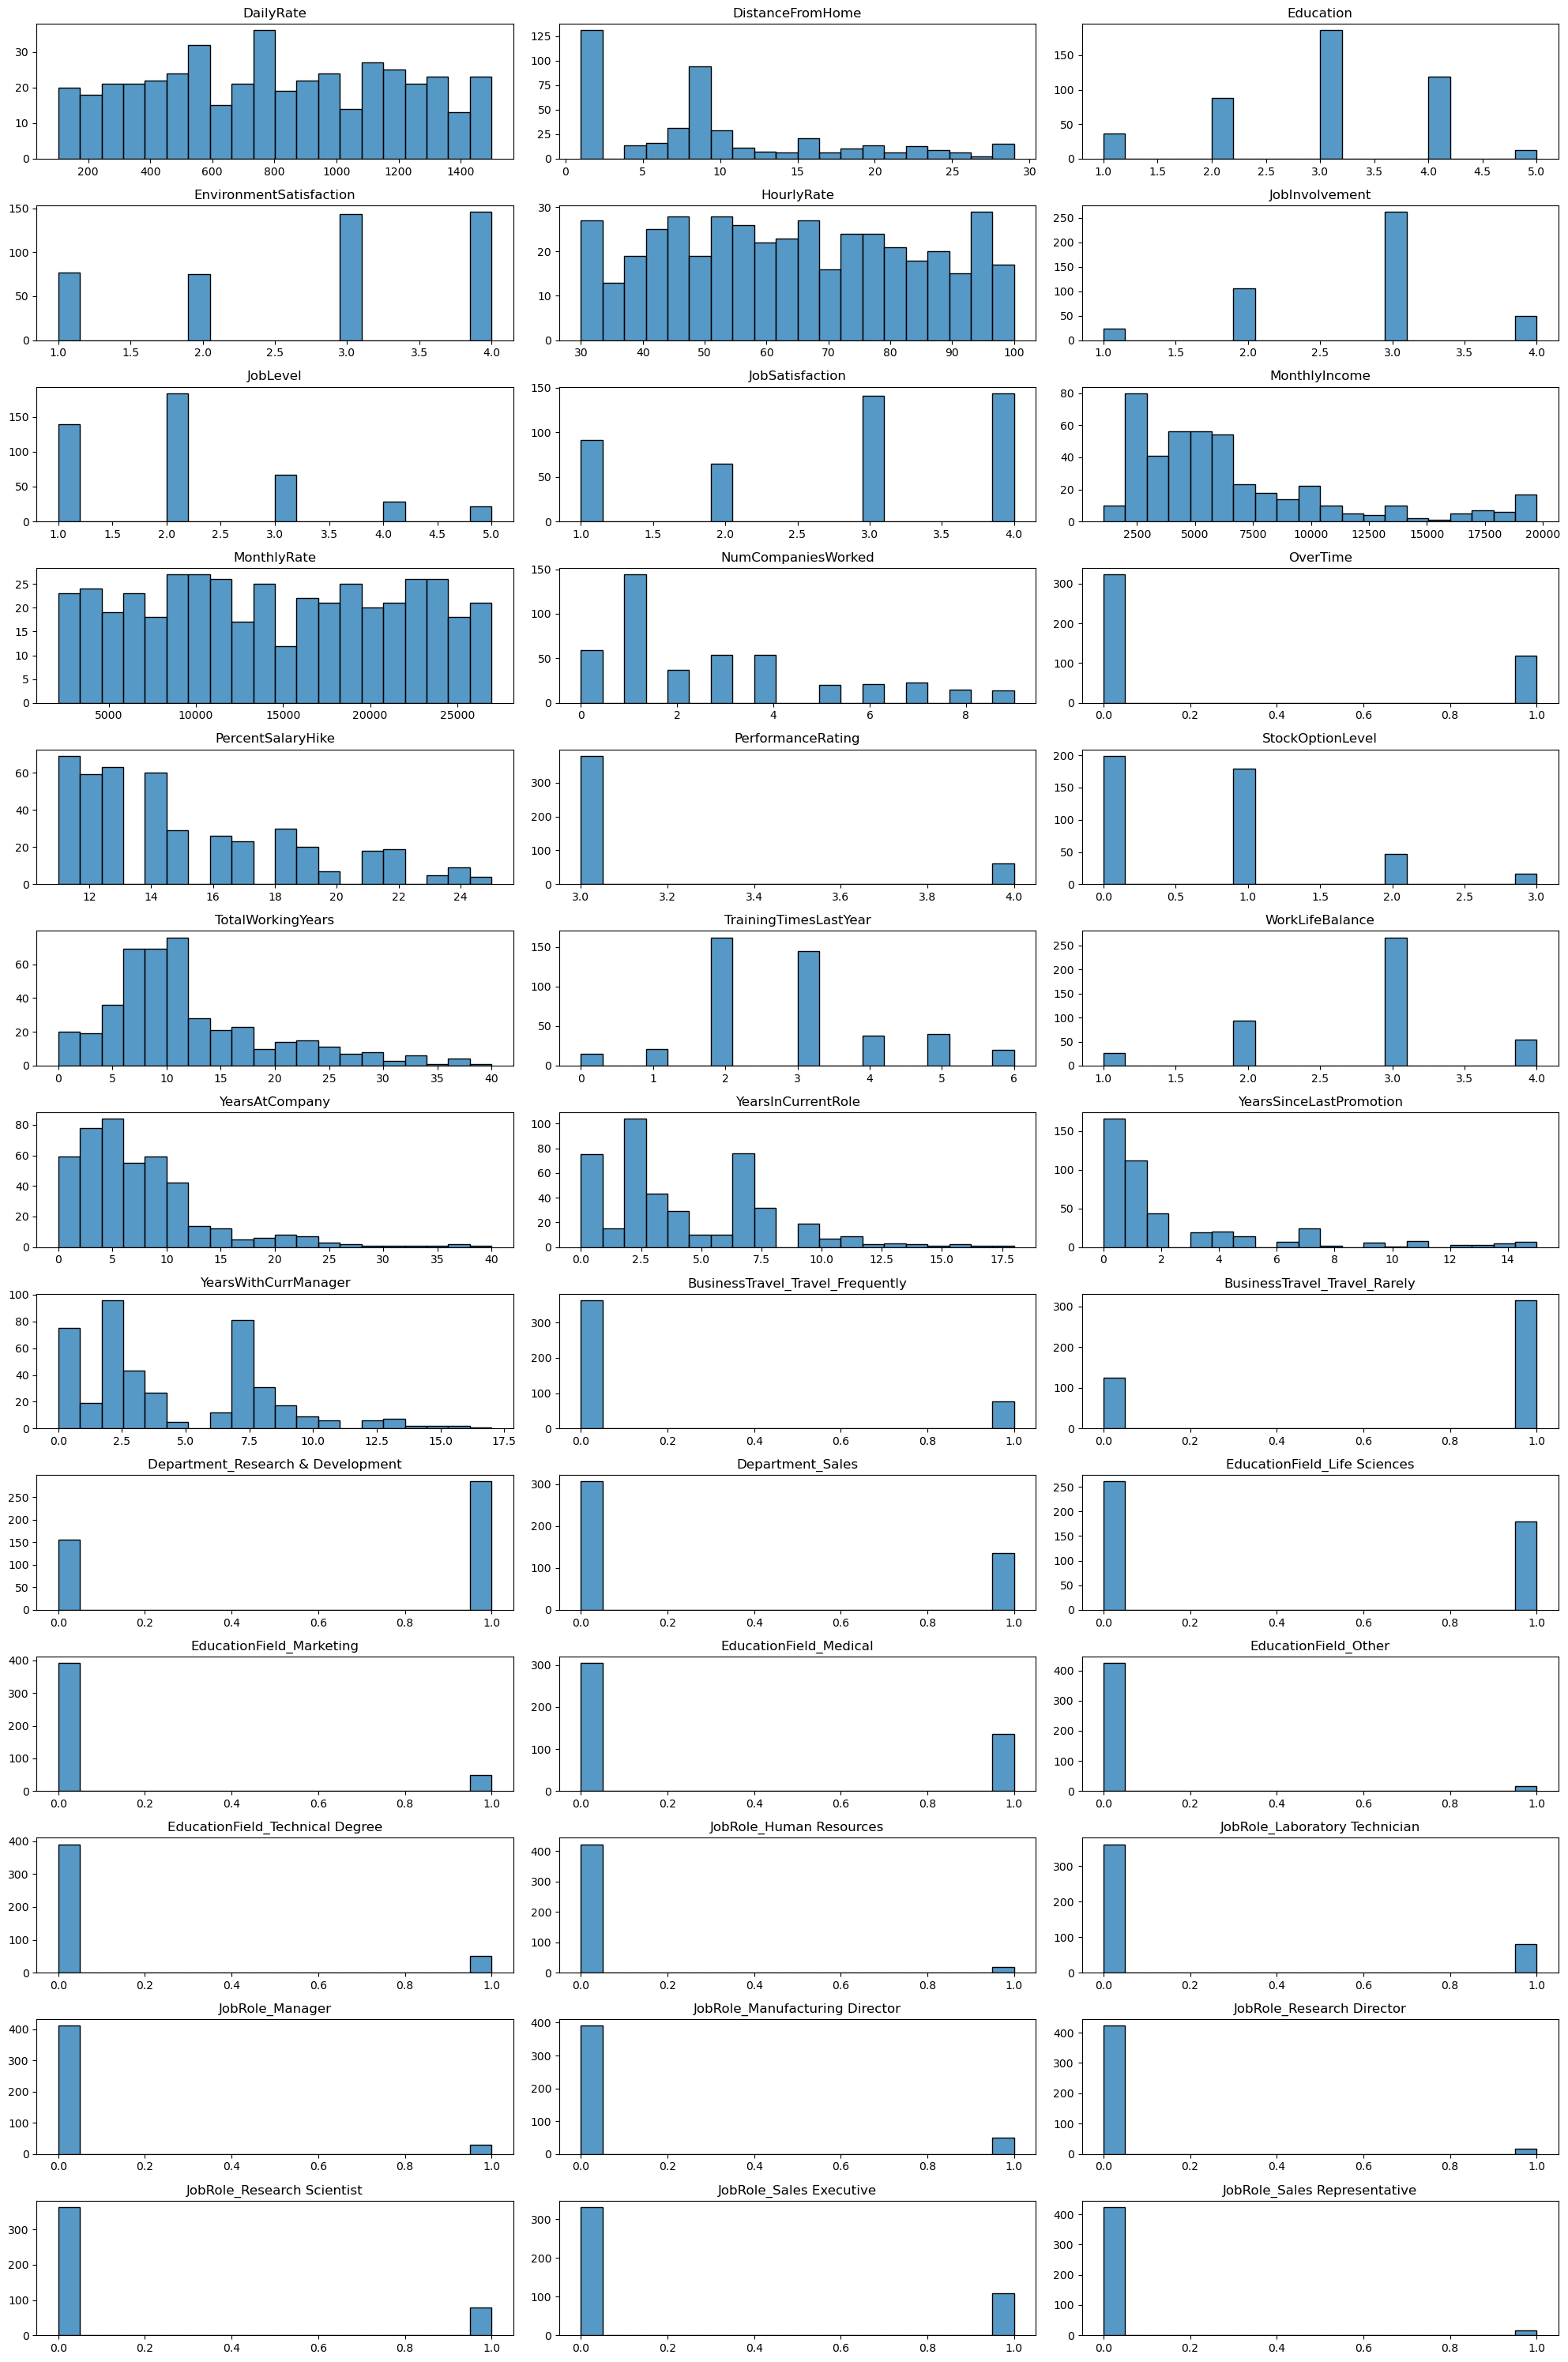

In [42]:
# Set up the figure
fig, axes = plt.subplots(13, 3, figsize=(20, 30))
axes = axes.flatten()  # Flatten in case of 2D grid

# Plot each histograms for each column
for i, col in enumerate(df_lyon.columns):
    sns.histplot(df_lyon[col], 
                 bins=20, 
                 kde=False, 
                 ax=axes[i])
    axes[i].set_title(f"{col}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
plt.tight_layout()
plt.show()

## 5.3. Predicting Likelihood of Leave

In [43]:
# Predict the probability of accepting the RCC using 'employee_attrition_lyon.csv' dataset
probabilities = best_model.predict_proba(df_lyon)[:, 1]  # Get predicted probabilities for positive class

# Create a DataFrame with the predicted probabilities and name the column 'ProbAcceptRCC'
submission_df = pd.DataFrame(probabilities, columns=["ProbAcceptRCC"])

# Save to CSV without the index, matching the order of df_lyon
# submission_df.to_csv("attrition_prediction.csv", index=False)

In [44]:
# See if the probabiliteis were saved correctly in .csv (compare with the .csv)
print(f"First 10 Probabilities:\n{probabilities[:10]}",
      f"\n\nLast 10 Probabilities:\n{probabilities[431:]}"
)

First 10 Probabilities:
[0.40417174 0.1507079  0.67780156 0.20560811 0.30183469 0.57101014
 0.31198785 0.42620515 0.50085975 0.48478834] 

Last 10 Probabilities:
[0.55199801 0.31087653 0.44579632 0.33322116 0.23642443 0.28439299
 0.3869018  0.90074181 0.20797857 0.8721443 ]


In [45]:
# Count how many predictions are above 0.5 (i.e., predicted to acccept RCC)
count_prob = np.sum(probabilities > 0.5)
total_prob = len(probabilities)
percentage = (count_prob / total_prob) * 100

print(f"Count above 0.5: {count_prob}",
      f"\nTotal: {total_prob}",
      f"\nPercentage: {percentage:.2f}%"
)

Count above 0.5: 106 
Total: 441 
Percentage: 24.04%


The model predicted 24.06% of employees to accept RCC and leave. Given the model imperfections, not all 24.04% are going to be true positives. Using the performance metric from the test set, where the model had predicted 22.10% of employees to accept RCC and leave, 47.5% of which were false positives, we can assume that a similar proportion would appear here.

To account for the uncertainty, I suggest including an error buffer for the budget based on the test set metrics. For example, based on accuracy of 83.4%, a 16.6% buffer. A more conservative, worst-case scenario where we offer RCC to all true positives and false negatives, the buffer could be based on TPR 66%, with a 34% buffer.

With a budget of EUR 3 million, these buffer costs are substantial. Instead, a limiting allocation strategy like first-come-first-served removes the need for the buffers and keeps the RCC costs under the set budget, while still being able to offer it to all predicted employees. However, a policy like this would need to be explicitly negotiated with the employee/union representatives.

# __6. TESTING__

## 6.1. Testing for Assignment Part 3

In [46]:
# Load the datasets
df_test1 = pd.read_csv('employee_attrition_lyon.csv')
df_test2 = pd.read_csv('attrition_prediction.csv')

# Drop 'protected characteristics' and not useful for analysis columns
feature_drop = [
    'EmployeeCount', 'Over18', 'StandardHours'                    # Not useful for analysis (single value features)
]  
df_test1.drop(feature_drop, axis=1, inplace=True)
df_test1.shape  # check if they got removed

#### DEAL WITH MISSING VALUES ####
# Impute categorical featues with the most frequent value and numerical features with the mean
BT_imputer = SimpleImputer(strategy='most_frequent')
df_test1[['BusinessTravel']] = BT_imputer.fit_transform(df_test1[['BusinessTravel']])
DR_imputer = SimpleImputer(strategy='mean')     # relatively balnced distribution
df_test1[['DailyRate']] = DR_imputer.fit_transform(df_test1[['DailyRate']])
DFH_imputer = SimpleImputer(strategy='median')  # skewed left distribution
df_test1[['DistanceFromHome']] = DFH_imputer.fit_transform(df_test1[['DistanceFromHome']])
MS_imputer = SimpleImputer(strategy='most_frequent')
df_test1[['MaritalStatus']] = MS_imputer.fit_transform(df_test1[['MaritalStatus']])
Age_imputer = SimpleImputer(strategy='mean')    # relatively normally distributed
df_test1[['Age']] = Age_imputer.fit_transform(df_test1[['Age']])

# Plot 'Age' histogram to see distribution
# plt.hist(df_test1['Age'].dropna(), bins=20, edgecolor='black')
# plt.title('Age Distribution')
# plt.xlabel('Age')
# plt.ylabel('Frequency')
# plt.grid(True)
# plt.show()

# Combine them column-wise
df_test = pd.concat([df_test1, df_test2], axis=1)
df_test.shape

(441, 32)

In [47]:
# Count the proportion of genders in the dataset
gender_percentages = df_test['Gender'].value_counts(normalize=True) * 100
print(gender_percentages.round(2))

Gender
Male      60.09
Female    39.91
Name: proportion, dtype: float64


In [48]:
# Count total number of employees per department
total_per_dept = df_test.groupby('Department').size()

# Display result
print(total_per_dept)

Department
Human Resources            21
Research & Development    285
Sales                     135
dtype: int64


In [49]:
# Filter data to only employees who do overtime
overtime_df = df_test[df_test['OverTime'] == 'Yes']

# Count employees who do overtime per department
overtime_counts = overtime_df.groupby('Department').size()

# Count males who do overtime per department
male_overtime_counts = overtime_df[overtime_df['Gender'] == 'Male'].groupby('Department').size()

# Calculate percentage of overtime employees who are male per department
male_overtime_percentage = (male_overtime_counts / overtime_counts * 100).round(2)

# Combine into one DataFrame for display
summary = pd.DataFrame({
    'Overtime_Count': overtime_counts,
    'Male_Overtime_%': male_overtime_percentage
}).fillna(0)

print(summary)


                        Overtime_Count  Male_Overtime_%
Department                                             
Human Resources                      5            80.00
Research & Development              74            56.76
Sales                               39            46.15


## 6.2. Groupping observations to use in optimization

#### AKNOWLEDGEMENT: _The following code chuck was obtained in its majority from ChatGPT LLM, while iteration algorithm is understood, writing-up was bayond my current ability_

In [50]:
# Recursive function to split employee data into fair groups based on defined features
def smart_split(df, features, min_size=5, max_size=20, path=""):
    # Base case: if group size is acceptable or no features left to split on
    if len(df) <= max_size or not features:
        df = df.copy()
        df["SplitPath"] = path if path else "No Split"
        return [df]

    # Take the current feature and condition to split on
    feature, condition = features[0]
    g1 = df[df[feature].apply(condition)]    # subgroup where condition is True
    g2 = df[~df[feature].apply(condition)]   # subgroup where condition is False

    # If either split subgroup is too small, skip this split and try the next feature
    if len(g1) < min_size or len(g2) < min_size:
        return smart_split(df, features[1:], min_size, max_size, path)

    # Build a readable path string for tracking group split logic
    cond_desc = (
        f"{feature}==1" if feature == "TotalWorkingYears" and condition(1)
        else f"{feature}==2" if feature == "TotalWorkingYears" and condition(2)
        else f"{feature}==1" if feature == "YearsAtCompany" and condition(1)
        else f"{feature}>=30" if feature == "YearsAtCompany" and condition(30)
        else f"{feature}==0" if feature == "StockOptionLevel"
        else f"{feature}==1" if feature == "JobLevel"
        else f"{feature} in income range" if feature == "MonthlyIncome"
        else feature
    )

    # Recurse on both subgroups, updating the split path
    return (
        smart_split(g1, features[1:], min_size, max_size, path + f"{' --> ' if path else ''}{cond_desc}=True") +
        smart_split(g2, features[1:], min_size, max_size, path + f"{' --> ' if path else ''}{cond_desc}=False")
    )


# Group ID string generator based on meaningful attributes
def get_group_seed(row):
    # Simplify department names
    dept = (
        "HR" if row["Department"] == "Human Resources"
        else "S" if row["Department"] == "Sales"
        else "RD"
    )
    ot = "Y" if row["OverTime"] == "Yes" else "N"

    # Group working years
    twy = "1" if row["TotalWorkingYears"] == 1 else "2" if row["TotalWorkingYears"] == 2 else "3+"
    jl = "1" if row["JobLevel"] == 1 else "2+"

    # Monthly income category
    if row["MonthlyIncome"] <= 2500:
        mi = "low"
    elif 9500 <= row["MonthlyIncome"] <= 10250:
        mi = "mid"
    else:
        mi = "other"

    # Years at company category
    if row["YearsAtCompany"] == 1:
        yac = "1"
    elif row["YearsAtCompany"] >= 30:
        yac = "30+"
    else:
        yac = "other"

    # Combined readable seed string
    return f"{dept}_OT:{ot}_TWY:{twy}_JL:{jl}_MI:{mi}_YAC:{yac}"


# ---------- MAIN PROCESS ----------

group_counter = 1
all_groups = []

# Split data by department first (HR, Sales, R&D)
for dept, df_dept in df_test.groupby("Department"):
    # Then split each department by OverTime status
    ot_group = df_dept[df_dept["OverTime"] == "Yes"]
    no_ot_group = df_dept[df_dept["OverTime"] != "Yes"]

    # Loop over both OT groups
    for ot_value, subset in zip(["Yes", "No"], [ot_group, no_ot_group]):
        if subset.empty:
            continue  # skip if group is empty

        base_path = f"OverTime={ot_value}"

        # Features to use for recursive splitting (in order of importance)
        conditions = [
            ("TotalWorkingYears", lambda x: x == 1),
            ("TotalWorkingYears", lambda x: x == 2),
            ("JobLevel", lambda x: x == 1),
            ("MonthlyIncome", lambda x: (x <= 2500) or (9500 <= x <= 10250)),
            ("YearsAtCompany", lambda x: x == 1 or x >= 30)
        ]

        # Run recursive splitter on the subset with the features above
        split_groups = smart_split(subset, conditions, path=base_path)

        # For each resulting group, assign GroupID and GroupSeed
        for g in split_groups:
            g = g.copy()
            g["GroupID"] = f"G{group_counter}"
            g["GroupSeed"] = g.apply(get_group_seed, axis=1)
            all_groups.append(g)
            group_counter += 1

# Concatenate all groups into a single DataFrame
df_grouped = pd.concat(all_groups).reset_index(drop=True)

# Optional: check for duplicate employees
if "EmployeeID" in df_grouped.columns:
    assert df_grouped["EmployeeID"].is_unique, "Duplicate employees across groups!"


# ---------- GROUP-LEVEL SUMMARY ----------

summary = df_grouped.groupby("GroupID").agg(
    Department=("Department", "first"),
    GroupSeed=("GroupSeed", "first"),
    GroupSize=("GroupID", "count"),
    Avg_Attrition_Probability=("ProbAcceptRCC", "mean"),
    Avg_MonthlyIncome=("MonthlyIncome", "mean"),
    Avg_YearsAtCompany=("YearsAtCompany", "mean")
).reset_index()

# Calculate expected leavers per group (will later be rounded in Excel)
summary["ExpectedLeavers"] = summary["GroupSize"] * summary["Avg_Attrition_Probability"]

# Show expected total leavers (for sanity check, should be ≥ 40 after filtering)
total_expected_leavers_under_20 = summary[summary["GroupSize"] < 20]["ExpectedLeavers"].sum()
print(f"Total expected leavers from groups with size < 20: {total_expected_leavers_under_20:.2f}")

# ---------- FILTERING FOR FINAL OPTIMIZATION ----------

# Keep only gender-diverse groups (at least 1 male + 1 female)
gender_check = df_grouped.groupby("GroupID")["Gender"].nunique()
valid_gender_groups = gender_check[gender_check >= 2].index
summary_gender_balanced = summary[summary["GroupID"].isin(valid_gender_groups)]

# Final filter: groups with size ≤ 20
summary_gender_balanced_under_20 = summary_gender_balanced[summary_gender_balanced["GroupSize"] <= 20].reset_index(drop=True)

# Export-ready dataset for Excel optimization
# summary_gender_balanced_under_20.to_excel("smm750-ICW_excel.xlsx", index=False)

# Preview final dataset
summary_gender_balanced_under_20


Total expected leavers from groups with size < 20: 47.61


,GroupID,Department,GroupSeed,GroupSize,Avg_Attrition_Probability,Avg_MonthlyIncome,Avg_YearsAtCompany,ExpectedLeavers
0,G1,Human Resources,HR_OT:Y_TWY:3+_JL:2+_MI:other_YAC:other,5,0.600457,5938.000000,8.800000,3.002283
1,G10,Research & Development,RD_OT:N_TWY:3+_JL:2+_MI:other_YAC:1,7,0.406671,5861.571429,6.571429,2.846696
2,G12,Sales,S_OT:Y_TWY:3+_JL:1_MI:other_YAC:other,6,0.625198,2660.333333,5.833333,3.751190
3,G14,Sales,S_OT:N_TWY:3+_JL:1_MI:low_YAC:other,11,0.457665,2511.818182,2.272727,5.034317
4,G15,Sales,S_OT:N_TWY:3+_JL:2+_MI:other_YAC:30+,8,0.398230,10859.500000,9.500000,3.185839
5,G2,Human Resources,HR_OT:N_TWY:1_JL:1_MI:low_YAC:1,16,0.375707,6651.312500,7.375000,6.011317
6,G3,Research & Development,RD_OT:Y_TWY:3+_JL:1_MI:low_YAC:other,7,0.776311,2088.142857,3.428571,5.434179
7,G4,Research & Development,RD_OT:Y_TWY:2_JL:1_MI:other_YAC:other,19,0.580270,3416.684211,4.157895,11.025135
8,G6,Research & Development,RD_OT:N_TWY:1_JL:1_MI:low_YAC:1,7,0.661607,2166.428571,0.857143,4.631250
9,G9,Research & Development,RD_OT:N_TWY:3+_JL:2+_MI:mid_YAC:1,10,0.269050,9022.800000,4.900000,2.690504
